In [1]:
# import the transcriptome data
import os
import dandelion as ddl
import pandas as pd
import scanpy as sc
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.4.1 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.7.1 leidenalg==0.8.2


In [2]:
ddl.logging.print_versions()

dandelion==0.0.27.post2 pandas==1.1.3 numpy==1.18.5 matplotlib==3.3.2 networkx==2.5 scipy==1.4.1 skbio==0.5.6


In [3]:
os.getcwd()

'/lustre/scratch117/cellgen/team297/kt16/newcastle_covid/notebooks'

In [4]:
os.chdir('/lustre/scratch117/cellgen/team297/kt16/newcastle_covid')

In [5]:
cellInfo = pd.read_csv('RDS/Merged_donors.tsv', index_col = 0, sep = '\t')
cellInfo

,donor_id,prob_max,prob_doublet,n_vars,best_singlet,best_doublet,Sample,sample_id,CellID
cell,,,,,,,,,
AAACCTGAGACCGGAT-1,CV0902,1.00000,2.960000e-10,111,CV0902,"CV0902,CV0025",BGCV01,BGCV01_CV0902,BGCV01_AAACCTGAGACCGGAT-1
AAACCTGAGAGGTAGA-1,CV0025,1.00000,1.720000e-04,49,CV0025,"CV0902,CV0144",BGCV01,BGCV01_CV0025,BGCV01_AAACCTGAGAGGTAGA-1
AAACCTGAGATGCGAC-1,CV0904,1.00000,1.500000e-20,89,CV0904,"CV0904,CV0144",BGCV01,BGCV01_CV0904,BGCV01_AAACCTGAGATGCGAC-1
AAACCTGAGCGCCTCA-1,CV0904,1.00000,7.280000e-11,51,CV0904,"CV0904,CV0902",BGCV01,BGCV01_CV0904,BGCV01_AAACCTGAGCGCCTCA-1
AAACCTGAGCGTGAAC-1,CV0025,1.00000,3.300000e-05,61,CV0025,"CV0902,CV0144",BGCV01,BGCV01_CV0025,BGCV01_AAACCTGAGCGTGAAC-1
...,...,...,...,...,...,...,...,...,...
TTTGTCAGTTACGGAG-1,CV0257,1.00000,9.860000e-06,58,CV0257,"CV0231,CV0944",BGCV15,BGCV15_CV0257,BGCV15_TTTGTCAGTTACGGAG-1
TTTGTCAGTTGGTGGA-1,doublet,0.09450,9.050000e-01,157,CV0176,"CV0176,CV0257",BGCV15,BGCV15_doublet,BGCV15_TTTGTCAGTTGGTGGA-1
TTTGTCATCCTATGTT-1,CV0176,1.00000,6.230000e-06,67,CV0176,"CV0176,CV0944",BGCV15,BGCV15_CV0176,BGCV15_TTTGTCATCCTATGTT-1


In [6]:
os.chdir('/lustre/scratch117/cellgen/team297/kt16/newcastle_covid/cambridge/BCR')

In [7]:
# For demultiplexing the BCR, i will use the Merged_donors.tsv to match up the barcodes first.
# had to manually change the file names from filtered_contig_annotation.csv to filtered_contig_annotations.csv
folders = ['BGCV01_BCR', 'BGCV02_BCR', 'BGCV03_BCR', 'BGCV04_BCR', 'BGCV05_BCR', 'BGCV06_BCR', 'BGCV07_BCR', 'BGCV08_BCR','BGCV09_BCR', 'BGCV10_BCR', 'BGCV11_BCR', 'BGCV12_BCR', 'BGCV13_BCR', 'BGCV14_BCR', 'BGCV15_BCR']
prefixes = [sample.split('_BCR')[0] for sample in folders]
ddl.pp.format_fastas(folders, prefix = prefixes, remove_trailing_hyphen_number=False)

Formating fasta(s) : 100%|██████████| 15/15 [01:21<00:00,  5.42s/it]


In [8]:
# repeat the BCR demultiplexing like what i did with Rik's data 
# currently there's 15 fasta files and contig annotations corresponding to the 60 patients, and the fasta headers and contig_annotations are now edited to match to the transcriptome barcodes, or CellID.
# so first, create a dictionary mapping the CellID to donor_id
barcode_dictionary = dict(zip(cellInfo['CellID'], cellInfo['donor_id']))
barcode_dictionary

{'BGCV01_AAACCTGAGACCGGAT-1': 'CV0902',
 'BGCV01_AAACCTGAGAGGTAGA-1': 'CV0025',
 'BGCV01_AAACCTGAGATGCGAC-1': 'CV0904',
 'BGCV01_AAACCTGAGCGCCTCA-1': 'CV0904',
 'BGCV01_AAACCTGAGCGTGAAC-1': 'CV0025',
 'BGCV01_AAACCTGAGCTTATCG-1': 'CV0904',
 'BGCV01_AAACCTGAGGAACTGC-1': 'CV0902',
 'BGCV01_AAACCTGAGGAGTCTG-1': 'CV0904',
 'BGCV01_AAACCTGAGGGATCTG-1': 'CV0902',
 'BGCV01_AAACCTGAGGGCATGT-1': 'CV0902',
 'BGCV01_AAACCTGAGGGCTCTC-1': 'doublet',
 'BGCV01_AAACCTGAGTATTGGA-1': 'unassigned',
 'BGCV01_AAACCTGAGTGAACAT-1': 'CV0902',
 'BGCV01_AAACCTGAGTGTCTCA-1': 'CV0904',
 'BGCV01_AAACCTGCAAACAACA-1': 'doublet',
 'BGCV01_AAACCTGCAACGCACC-1': 'CV0902',
 'BGCV01_AAACCTGCACACGCTG-1': 'CV0902',
 'BGCV01_AAACCTGCACAGACAG-1': 'unassigned',
 'BGCV01_AAACCTGCACCAACCG-1': 'unassigned',
 'BGCV01_AAACCTGCACGTGAGA-1': 'CV0902',
 'BGCV01_AAACCTGCAGACACTT-1': 'doublet',
 'BGCV01_AAACCTGCAGCTGCTG-1': 'CV0904',
 'BGCV01_AAACCTGCAGCTGTGC-1': 'CV0904',
 'BGCV01_AAACCTGCAGTCAGAG-1': 'CV0902',
 'BGCV01_AAACCTGCAGTCGTGC

In [9]:
# specify file paths
folders = ['BGCV01_BCR', 'BGCV02_BCR', 'BGCV03_BCR', 'BGCV04_BCR', 'BGCV05_BCR', 'BGCV06_BCR', 'BGCV07_BCR', 'BGCV08_BCR','BGCV09_BCR', 'BGCV10_BCR', 'BGCV11_BCR', 'BGCV12_BCR', 'BGCV13_BCR', 'BGCV14_BCR', 'BGCV15_BCR']
contig_files = [f +'/dandelion/data/filtered_contig_annotations.csv' for f in folders]
fasta_files = [f + '/dandelion/data/filtered_contig.fasta' for f in folders]

In [16]:
# append all the contig_annotation files into a single data frame
# skipping format_fastas because of how i need to do the manual editing
contig_annotations = pd.DataFrame()
for i in range(len(contig_files)):
    annot = pd.read_csv(contig_files[i])
    # add the patient_id here
    annot['patient_id'] = [barcode_dictionary[b] if b in barcode_dictionary.keys() else None for b in annot['barcode']]
    contig_annotations = contig_annotations.append(annot)

In [18]:
# create a dictionary mapping contig_id to patient_id
contig_dict = dict(zip(contig_annotations['contig_id'], contig_annotations['patient_id']))

In [19]:
# what are the unique patient_ids?
sorted([l for l in list(set(contig_annotations['patient_id'])) if l is not None])

['CV0025',
 'CV0037',
 'CV0050',
 'CV0052',
 'CV0058',
 'CV0059',
 'CV0062',
 'CV0068',
 'CV0073',
 'CV0074',
 'CV0084',
 'CV0094',
 'CV0100',
 'CV0104',
 'CV0120',
 'CV0128',
 'CV0134',
 'CV0137',
 'CV0144',
 'CV0155',
 'CV0160',
 'CV0164',
 'CV0171',
 'CV0176',
 'CV0178',
 'CV0180',
 'CV0198',
 'CV0200',
 'CV0201',
 'CV0231',
 'CV0234',
 'CV0257',
 'CV0262',
 'CV0279',
 'CV0284',
 'CV0326',
 'CV0902',
 'CV0904',
 'CV0911',
 'CV0915',
 'CV0917',
 'CV0926',
 'CV0929',
 'CV0934',
 'CV0939',
 'CV0940',
 'CV0944',
 'doublet',
 'unassigned']

In [21]:
patients = [l for l in list(set(contig_annotations['patient_id'])) if l is not None and l != 'doublet' and l != 'unassigned']
patients

['CV0279',
 'CV0257',
 'CV0037',
 'CV0074',
 'CV0904',
 'CV0128',
 'CV0262',
 'CV0052',
 'CV0915',
 'CV0926',
 'CV0917',
 'CV0944',
 'CV0062',
 'CV0059',
 'CV0326',
 'CV0939',
 'CV0231',
 'CV0201',
 'CV0178',
 'CV0104',
 'CV0068',
 'CV0902',
 'CV0073',
 'CV0100',
 'CV0144',
 'CV0120',
 'CV0929',
 'CV0171',
 'CV0050',
 'CV0025',
 'CV0911',
 'CV0234',
 'CV0160',
 'CV0094',
 'CV0155',
 'CV0058',
 'CV0180',
 'CV0940',
 'CV0198',
 'CV0934',
 'CV0134',
 'CV0084',
 'CV0284',
 'CV0200',
 'CV0176',
 'CV0164',
 'CV0137']

In [22]:
# read in the fasta files as a dictionary
from dandelion.utilities import fasta_iterator, Write_output
# create empty dictionaries to hold the fasta header and corresponding sequence. Doing this with defaultdict so I don't have to keep writing the code
from collections import defaultdict
dct = defaultdict(dict)
for i in range(len(fasta_files)):
    fh = open(fasta_files[i], 'r')
    for header, sequence in fasta_iterator(fh):
        for p in patients:
            if contig_dict[header] == p:
                dct[p][header] = sequence
    fh.close()    

In [23]:
# so the idea is to create a new folder holding the matched up contigs and annotations in a folder for each patient.
for k in dct.keys():
    # create out paths
    if not os.path.exists(k+'/dandelion/data'):
        os.makedirs(k+'/dandelion/data')
    # create name for out names
    out_fasta = k + '/dandelion/data/filtered_contig.fasta'
    out_annot = k + '/dandelion/data/filtered_contig_annotations.csv'
    fh1 = open(out_fasta, 'w')
    fh1.close()
    out = ''
    for l in dct[k]:
        out = '>'+l+'\n'+dct[k][l]+'\n'
        Write_output(out, out_fasta)
    data = contig_annotations[contig_annotations['patient_id'] == k].copy()
    data.to_csv(out_annot, index = False)

In [26]:
# Now to start dandelion pre-processing proper
ddl.pp.reannotate_genes(patients)

Assigning genes : 100%|██████████| 47/47 [19:53<00:00, 25.40s/it]


In [27]:
# run reassign alleles
# create a dictionary to facilitate that. Using this dictionary means it should just return the results back into the original folder.
group_dict = dict(zip(patients, patients))

In [28]:
group_dict

{'CV0279': 'CV0279',
 'CV0257': 'CV0257',
 'CV0037': 'CV0037',
 'CV0074': 'CV0074',
 'CV0904': 'CV0904',
 'CV0128': 'CV0128',
 'CV0262': 'CV0262',
 'CV0052': 'CV0052',
 'CV0915': 'CV0915',
 'CV0926': 'CV0926',
 'CV0917': 'CV0917',
 'CV0944': 'CV0944',
 'CV0062': 'CV0062',
 'CV0059': 'CV0059',
 'CV0326': 'CV0326',
 'CV0939': 'CV0939',
 'CV0231': 'CV0231',
 'CV0201': 'CV0201',
 'CV0178': 'CV0178',
 'CV0104': 'CV0104',
 'CV0068': 'CV0068',
 'CV0902': 'CV0902',
 'CV0073': 'CV0073',
 'CV0100': 'CV0100',
 'CV0144': 'CV0144',
 'CV0120': 'CV0120',
 'CV0929': 'CV0929',
 'CV0171': 'CV0171',
 'CV0050': 'CV0050',
 'CV0025': 'CV0025',
 'CV0911': 'CV0911',
 'CV0234': 'CV0234',
 'CV0160': 'CV0160',
 'CV0094': 'CV0094',
 'CV0155': 'CV0155',
 'CV0058': 'CV0058',
 'CV0180': 'CV0180',
 'CV0940': 'CV0940',
 'CV0198': 'CV0198',
 'CV0934': 'CV0934',
 'CV0134': 'CV0134',
 'CV0084': 'CV0084',
 'CV0284': 'CV0284',
 'CV0200': 'CV0200',
 'CV0176': 'CV0176',
 'CV0164': 'CV0164',
 'CV0137': 'CV0137'}

In [30]:
for folder_key, folder_value in group_dict.items():
    ddl.pp.reassign_alleles(folder_value, combined_folder = folder_key, sample_id_dictionary = group_dict, plot = False)

Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
      Novel allele discovery execution halted.
      Attempting to run tigger-genotype without novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Processing data file(s) : 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


      Running tigger-genotype with novel allele discovery.
      Reassigning alleles
            Reconstructing heavy chain dmask germline sequences with v_call_genotyped.
            Reconstructing light chain dmask germline sequences with v_call.
      For convenience, entries for light chain `v_call` are copied to `v_call_genotyped`.


Writing out to individual folders : 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 1683/1683 [00:01<00:00, 869.39it/s]


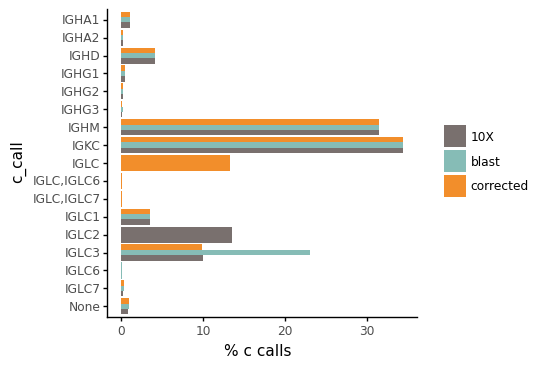

<ggplot: (1422750540929)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 2871/2871 [00:02<00:00, 1313.02it/s]


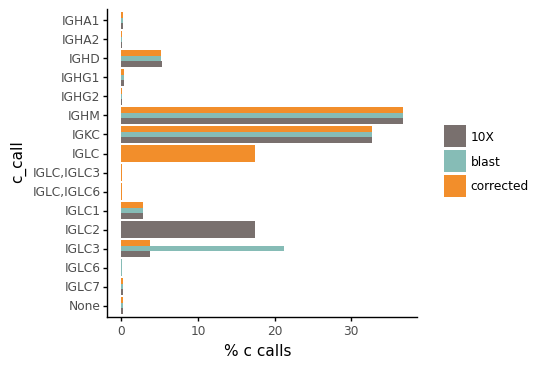

<ggplot: (1422741682165)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 1808/1808 [00:00<00:00, 3050.89it/s]


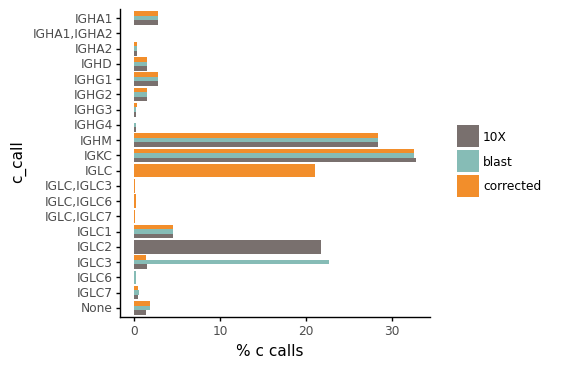

<ggplot: (1422742425937)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 4601/4601 [00:05<00:00, 778.51it/s] 


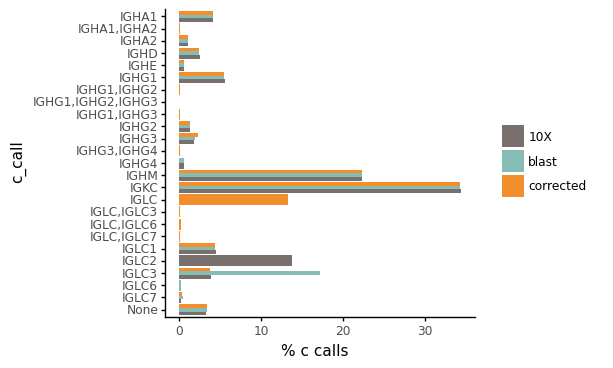

<ggplot: (1422742563657)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 2182/2182 [00:01<00:00, 2149.75it/s]


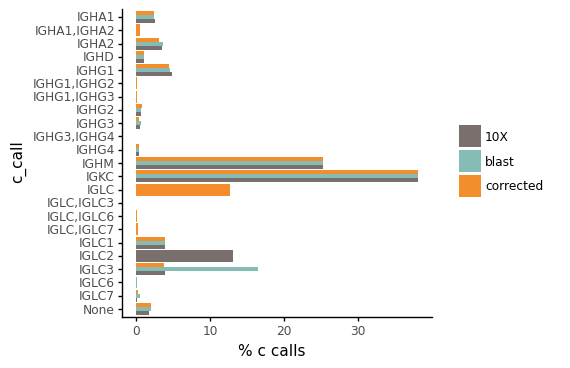

<ggplot: (1422841490229)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 2001/2001 [00:01<00:00, 1845.57it/s]


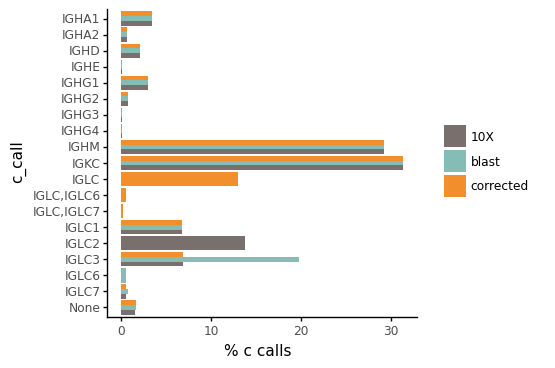

<ggplot: (1422753299693)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 1521/1521 [00:00<00:00, 2500.72it/s]


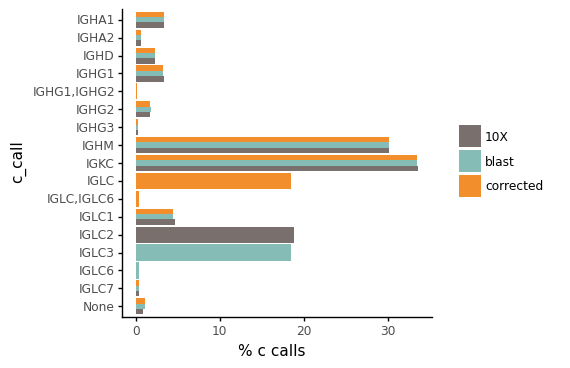

<ggplot: (1422750386005)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 2401/2401 [00:01<00:00, 2151.30it/s]


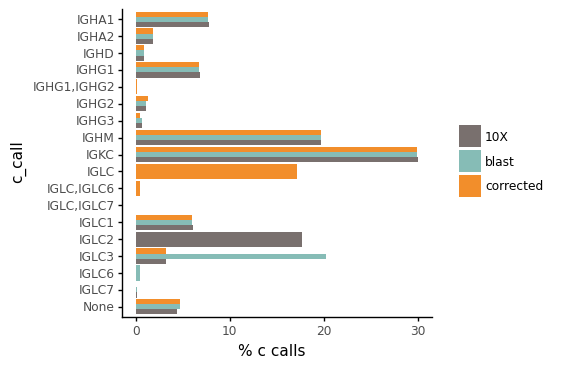

<ggplot: (1422750626373)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 720/720 [00:00<00:00, 2676.00it/s]


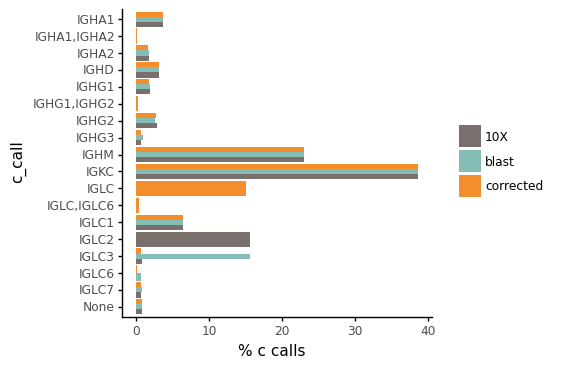

<ggplot: (1422732683261)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 655/655 [00:00<00:00, 2429.43it/s]


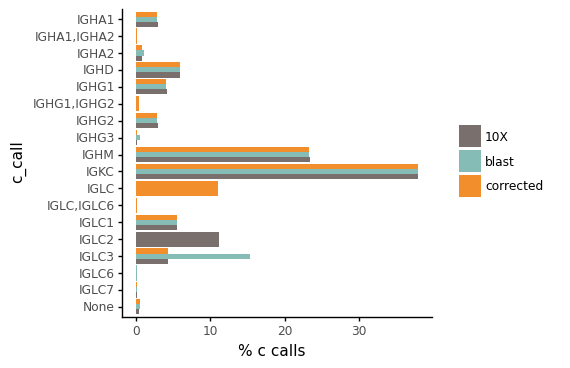

<ggplot: (1422741876085)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 769/769 [00:00<00:00, 3045.06it/s]


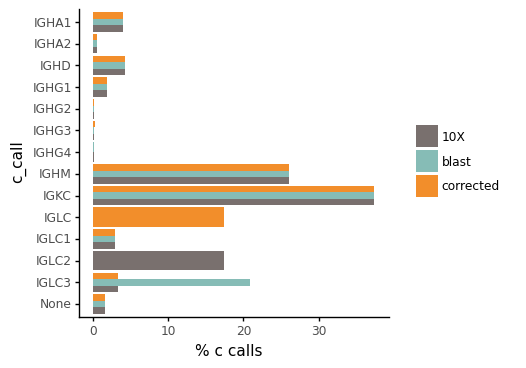

<ggplot: (1422750593485)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 417/417 [00:00<00:00, 1136.78it/s]


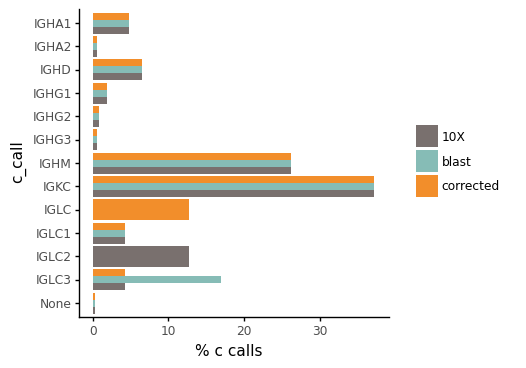

<ggplot: (1422760591005)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 2081/2081 [00:01<00:00, 1672.61it/s]


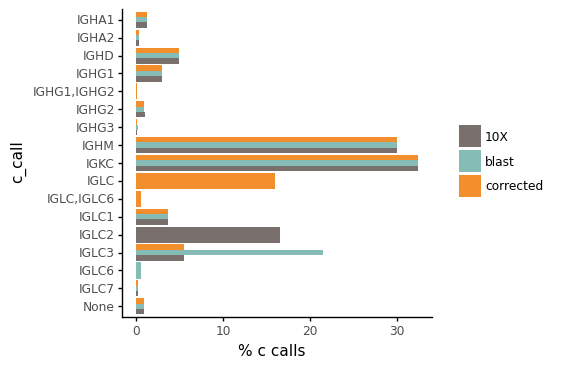

<ggplot: (1422742660605)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 855/855 [00:00<00:00, 3314.75it/s]


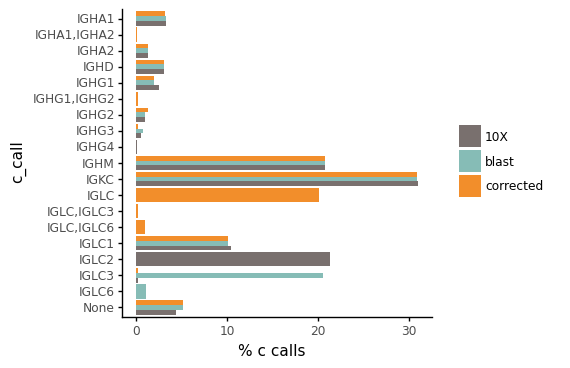

<ggplot: (1422742568497)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 1230/1230 [00:00<00:00, 3345.99it/s]


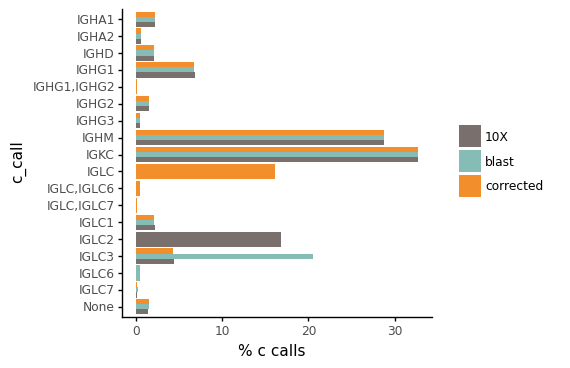

<ggplot: (1422743562977)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 800/800 [00:00<00:00, 3042.66it/s]


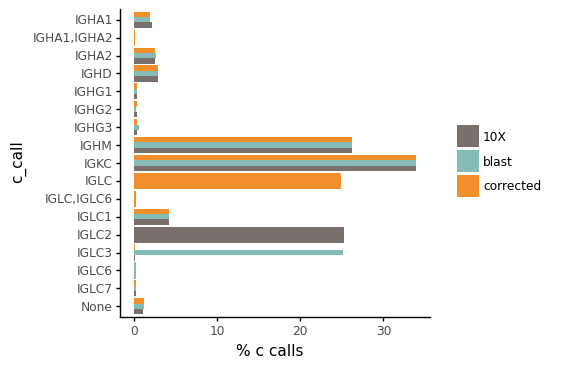

<ggplot: (1422750464165)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 1444/1444 [00:00<00:00, 1667.48it/s]


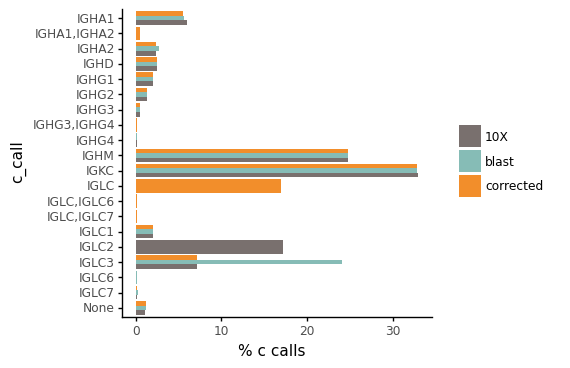

<ggplot: (1422750123469)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 2461/2461 [00:01<00:00, 1425.51it/s]


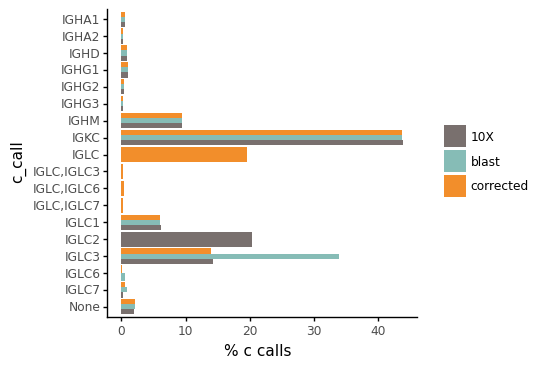

<ggplot: (1422850279917)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 2849/2849 [00:02<00:00, 1282.90it/s]


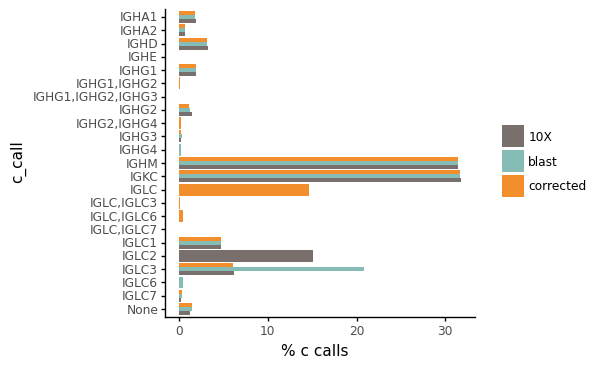

<ggplot: (1422839163129)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 548/548 [00:00<00:00, 3034.42it/s]


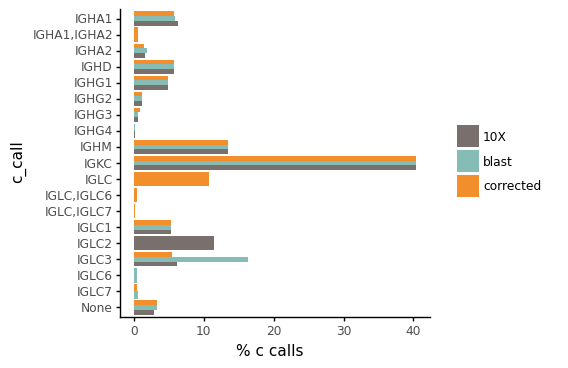

<ggplot: (1422742552557)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 2447/2447 [00:01<00:00, 1625.95it/s]


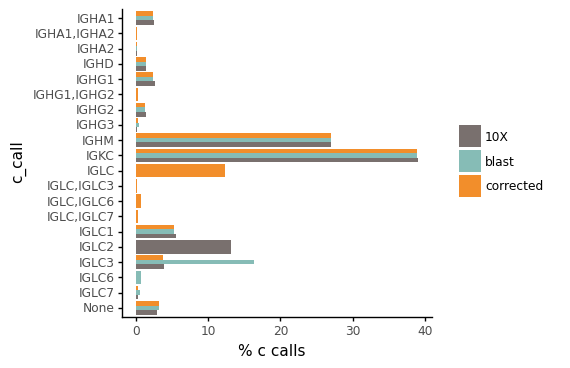

<ggplot: (1422841568505)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 2237/2237 [00:00<00:00, 2302.54it/s]


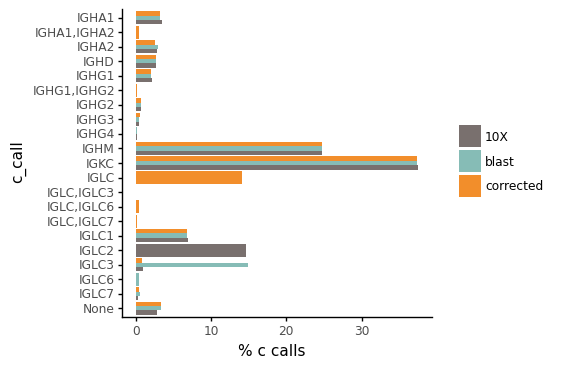

<ggplot: (1422742016493)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 2853/2853 [00:02<00:00, 1296.34it/s]


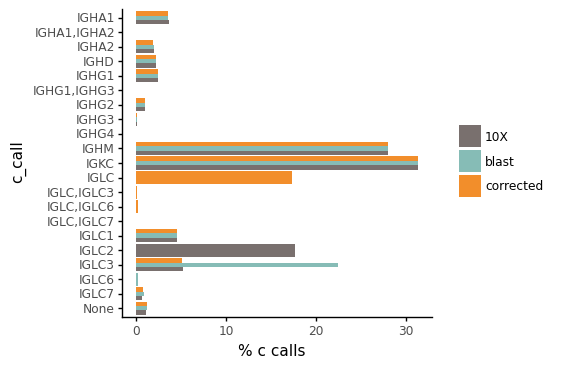

<ggplot: (1422742369409)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 2972/2972 [00:02<00:00, 1161.28it/s]


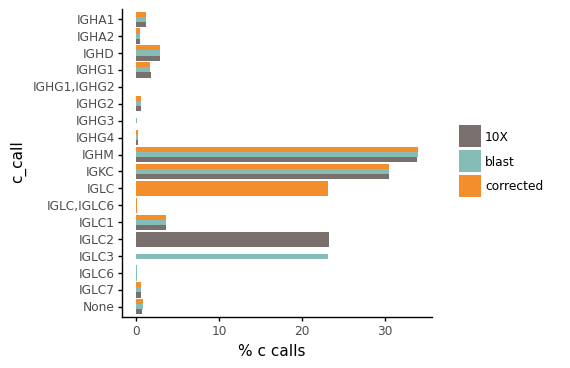

<ggplot: (1422850040845)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 548/548 [00:00<00:00, 3405.63it/s]


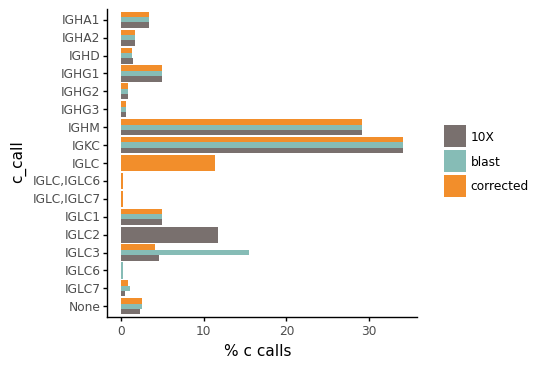

<ggplot: (1422750394725)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 527/527 [00:00<00:00, 2640.76it/s]


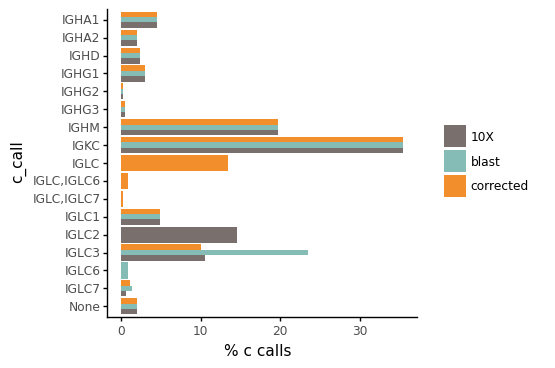

<ggplot: (1422850220205)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 1459/1459 [00:00<00:00, 2890.02it/s]


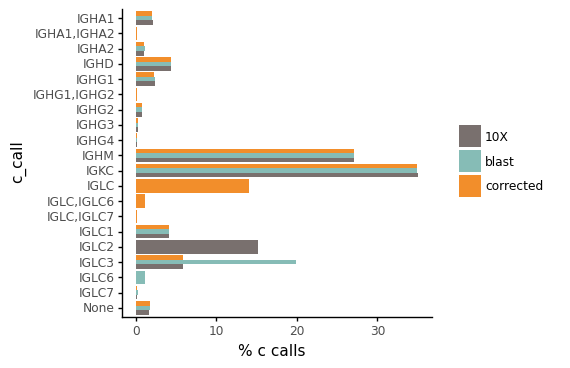

<ggplot: (1422741788257)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 4493/4493 [00:06<00:00, 691.61it/s]


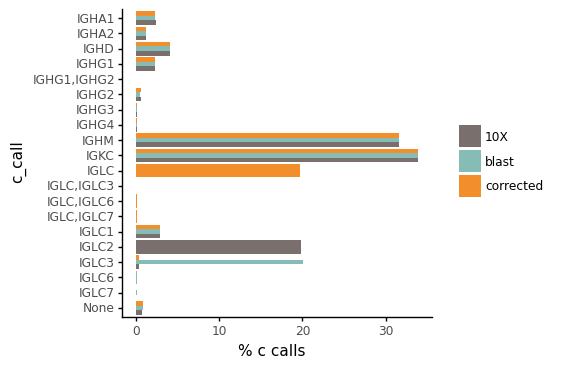

<ggplot: (1422841518709)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 1306/1306 [00:00<00:00, 3596.23it/s]


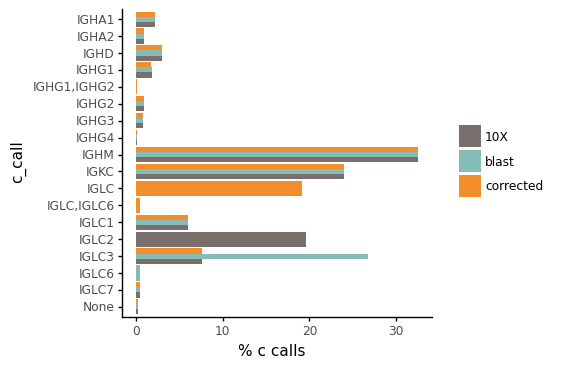

<ggplot: (1422753430929)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 1071/1071 [00:00<00:00, 3276.82it/s]


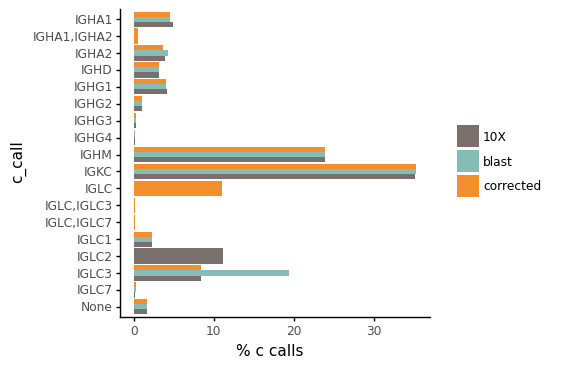

<ggplot: (1422741635777)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 597/597 [00:00<00:00, 3716.58it/s]


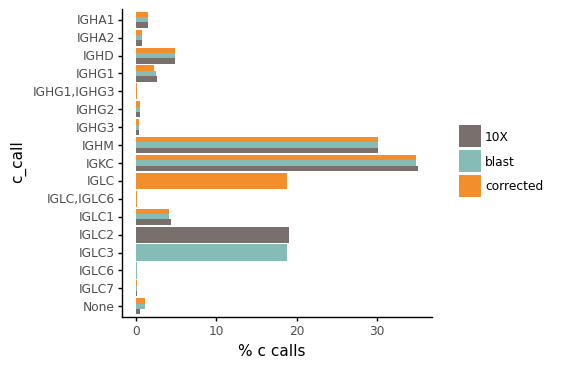

<ggplot: (1422850255029)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 2152/2152 [00:00<00:00, 2177.76it/s]


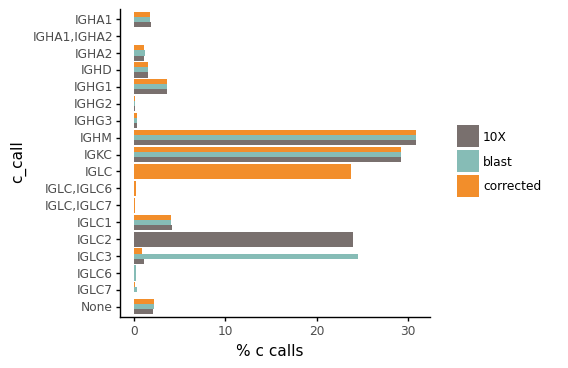

<ggplot: (1422743008013)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 1428/1428 [00:00<00:00, 2641.46it/s]


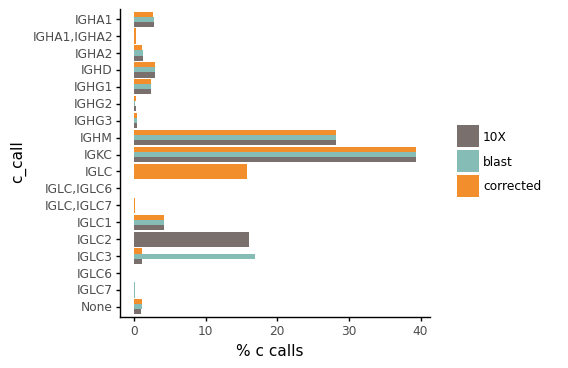

<ggplot: (1422743028713)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 2649/2649 [00:01<00:00, 1332.35it/s]


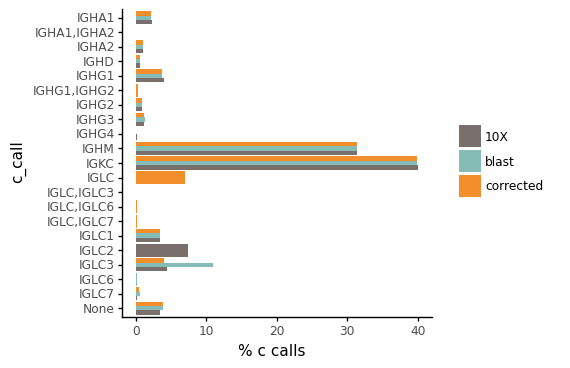

<ggplot: (1422850105121)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 1279/1279 [00:00<00:00, 2460.94it/s]


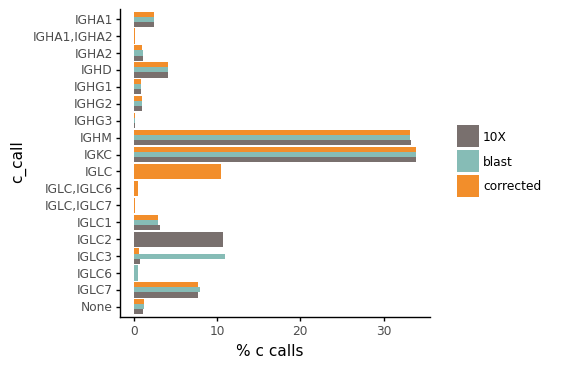

<ggplot: (1422850102181)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 831/831 [00:00<00:00, 3383.65it/s]


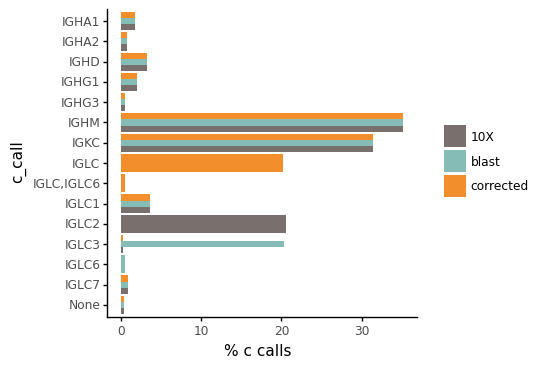

<ggplot: (1422752916125)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 555/555 [00:00<00:00, 3202.16it/s]


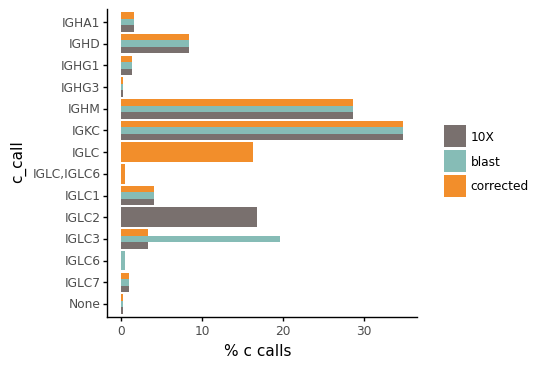

<ggplot: (1422850066165)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 695/695 [00:00<00:00, 2584.40it/s]


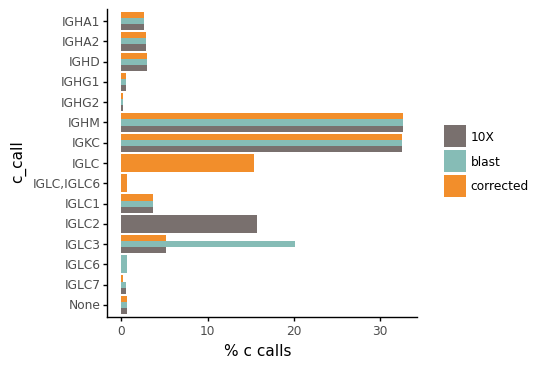

<ggplot: (1422743030241)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 5878/5878 [00:10<00:00, 546.80it/s]


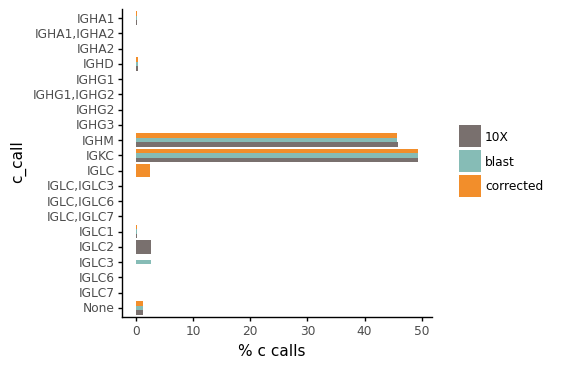

<ggplot: (1422850258365)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 1262/1262 [00:00<00:00, 3315.28it/s]


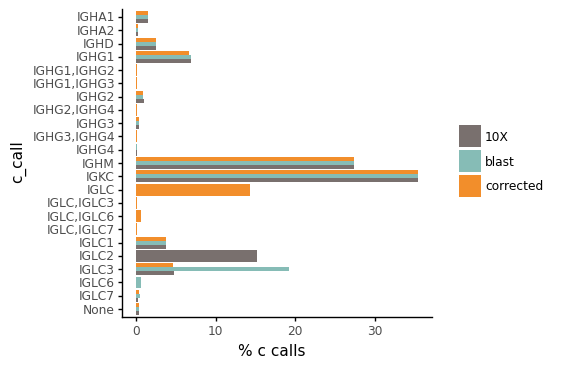

<ggplot: (1422753244373)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 1600/1600 [00:00<00:00, 2541.44it/s]


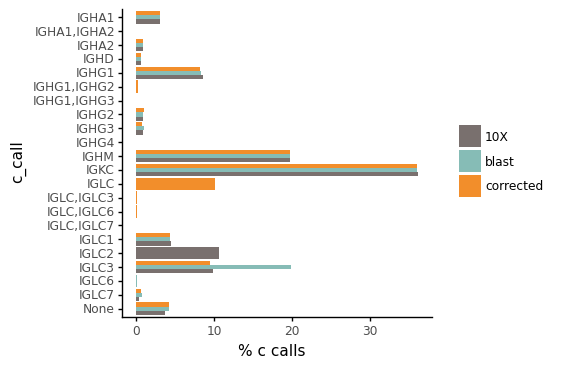

<ggplot: (1422743415185)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 253/253 [00:00<00:00, 2649.28it/s]


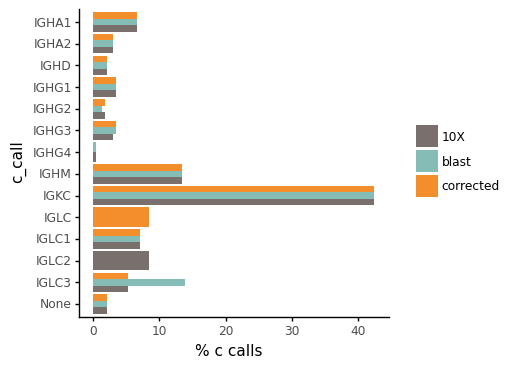

<ggplot: (1422750174637)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 2606/2606 [00:01<00:00, 1330.40it/s]


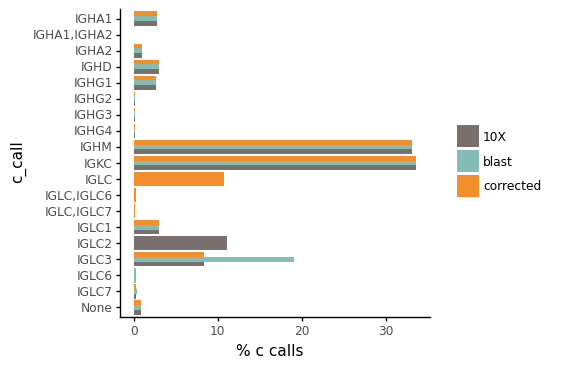

<ggplot: (1422850104417)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 1846/1846 [00:00<00:00, 3269.03it/s]


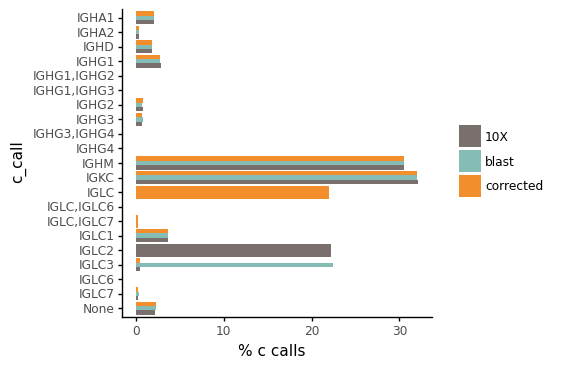

<ggplot: (1422750314037)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 614/614 [00:00<00:00, 1949.94it/s]


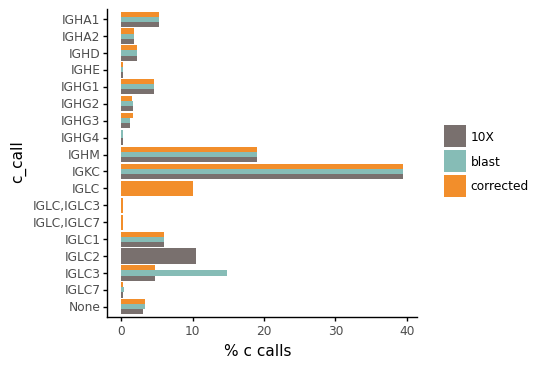

<ggplot: (1422850154817)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 986/986 [00:00<00:00, 2349.56it/s]


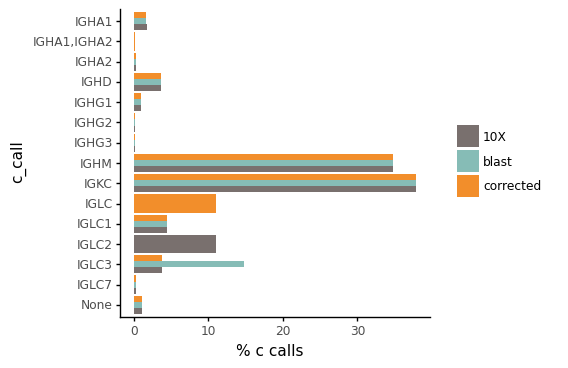

<ggplot: (1422753379313)>


Retrieving contant region calls, parallelizing with 63 cpus : 100%|██████████| 1785/1785 [00:00<00:00, 2227.85it/s]


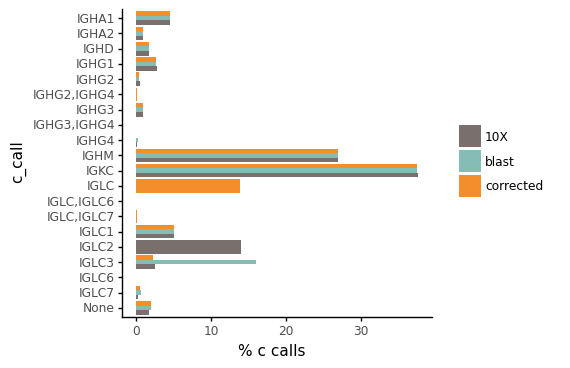

<ggplot: (1422753219105)>


In [31]:
ddl.pp.assign_isotypes(patients)

In [32]:
from tqdm import tqdm
# quantify mutations
for s in tqdm(patients, desc = 'Basic mutational load analysis '):
    filePath = s+'/dandelion/data/filtered_contig_igblast_db-pass_genotyped.tsv'
    ddl.pp.quantify_mutations(filePath)

Basic mutational load analysis : 100%|██████████| 47/47 [03:52<00:00,  4.95s/it]
